In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import hypergeom

In [2]:
data = pd.read_csv("~/Downloads/gocams2genes_20220728.txt", header=0, names=["gocam", "title", "gp_labels","ID","taxon","taxon_label","modelstate"], sep="\t")
data['gp_labels'] = data['gp_labels'].apply(lambda x: x.split(','))
data['ID'] = data['ID'].apply(lambda x: x.split(','))
data['title']=data['title'].apply(lambda x: x.split('^')[0])
data['modelstate']=data['modelstate'].apply(lambda x: x.split('^')[0])
data['gocam']=data['gocam'].apply(lambda x: x[1:len(x)-1])
data = data[data['taxon_label'].apply(lambda x: ('Homo sapiens' in x) or ('Mus musculus' in x))]
data = data[['gocam','title','ID']]

In [3]:
reactome_data = pd.read_csv("~/Downloads/metabolic_gocams2genes_20220728.tsv", header=0, names=["gocam", "title", "ID","taxon","taxon_labels","modelstate"], sep="\t")
reactome_data['ID'] = reactome_data['ID'].apply(lambda x: x.split(','))
reactome_data['taxon_labels'] = reactome_data['taxon_labels'].apply(lambda x: x.split(','))
reactome_data['title']=reactome_data['title'].apply(lambda x: x.split('^')[0])
reactome_data['modelstate']=reactome_data['modelstate'].apply(lambda x: x.split('^')[0])
reactome_data['gocam']=reactome_data['gocam'].apply(lambda x: x[1:len(x)-1])
reactome_data = reactome_data[reactome_data['taxon_labels'].apply(lambda x: 'Homo sapiens' in x)]
reactome_data = reactome_data[['gocam','title','ID']]

In [4]:
#GO CAMs with multiple taxon labels
t = data[data['gocam'].duplicated(keep=False)]
#t.sort_values(by='gocam')

In [5]:
#THERE ARE A FEW INSTANCES OF ONE GOCAM HAVING MORE THAN ONE TAXON LISTED
#ex: 5e72450500004019 has both R1AB_SARS2 and pp1ab Scov2
len(data.gocam.unique())

142

In [6]:
dataAsMatrix = pd.DataFrame()
#splits the lists of genes into multiple rows because row[ID] is a list
d = pd.concat([data,reactome_data])
for index, row in d.iterrows():
    temp= pd.DataFrame({"gocam": row['gocam'], "title":row['title'],"ID": row['ID'] })
    dataAsMatrix = dataAsMatrix.append(temp)
dataAsMatrix[['gocam','title','ID']].drop_duplicates()
dataAsMatrix.reset_index(drop=True, inplace=True)
dataAsMatrix
data = d

(array([528., 272., 128.,  43.,  20.,  18.,  13.,   5.,   3.,   1.]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <BarContainer object of 10 artists>)

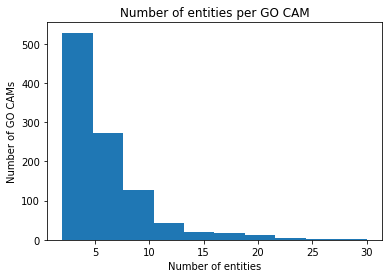

In [7]:
# DISTRIBUTION OF NUMBER OF GENES PER GOCAM
dist = data['ID'].str.len().values
fig = plt.hist(dist,10,range=(2,30))
plt.title('Number of entities per GO CAM')
plt.ylabel('Number of GO CAMs')
plt.xlabel('Number of entities')
fig

In [8]:
len(dataAsMatrix),len(dataAsMatrix.drop_duplicates()),len(dataAsMatrix[['gocam','title','ID']].drop_duplicates()), len(dataAsMatrix[['gocam','ID']].drop_duplicates())


(6218, 6209, 6209, 6209)

In [9]:
dataAsMatrix[dataAsMatrix[['gocam','ID']].duplicated()]

,gocam,title,ID
6195,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q8N884
6196,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q86WV6
6197,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q92993-4
6201,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/O75531
6203,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/P31749
6204,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/P42574
6205,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/O00743
6206,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9UHD2
6207,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9BRZ2


In [10]:
data[data['gocam']=='http://model.geneontology.org/60ad85f700000058']

,gocam,title,ID
89,http://model.geneontology.org/60ad85f700000058,Atf2 mouse,"[http://identifiers.org/mgi/MGI:109349, http:/..."


In [11]:
#confirming that my conversion worked
sum(dist)

6218

In [12]:
# NUMBER OF GENES OF EACH IDENTIFIER TYPE ACROSS GOCAMS
d = dataAsMatrix
d = d[['ID']].drop_duplicates()
d.reset_index(drop=True, inplace=True)
d['ID']= d['ID'].apply(lambda x: x.rsplit("/",1)[0])
d.ID.value_counts()

http://purl.obolibrary.org/obo/go/extensions    3076
http://identifiers.org/mgi                       301
http://identifiers.org/uniprot                   265
https://www.ebi.ac.uk/complexportal/complex        2
http://purl.obolibrary.org/obo                     2
http://rnacentral.org/rna                          1
Name: ID, dtype: int64

In [13]:
# NUMBER OF *OCCURENCES* OF GENES WITH EACH IDENFIFIER TYPE ACROSS GOCAMS
d = dataAsMatrix
d = d[['gocam','ID']].drop_duplicates()
d.reset_index(drop=True, inplace=True)
#d = d[d['ID'].apply(lambda x: x.split("/")[-2])=='uniprot']
d['ID']= d['ID'].apply(lambda x: x.rsplit("/",1)[0])
d.ID.value_counts()

http://purl.obolibrary.org/obo/go/extensions    5315
http://identifiers.org/mgi                       518
http://identifiers.org/uniprot                   371
https://www.ebi.ac.uk/complexportal/complex        2
http://purl.obolibrary.org/obo                     2
http://rnacentral.org/rna                          1
Name: ID, dtype: int64

In [14]:
data_cleaned = dataAsMatrix
data_cleaned = data_cleaned[['gocam','ID']].drop_duplicates()
data_cleaned.reset_index(drop=True, inplace=True)
data_cleaned

,gocam,ID
0,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:98724
1,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:108088
2,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:95294
3,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:95805
4,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:99511
...,...,...
6204,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/O95427
6205,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/Q9NUD9
6206,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/Q92521
6207,http://model.geneontology.org/5970219a00000013,http://purl.obolibrary.org/obo/GO_0032991


In [15]:
test= data_cleaned.copy()
test = test[test['ID'].apply(lambda x: x.split("/")[-2])=='uniprot']
test['ID']= test['ID'].apply(lambda x: x.split("/")[-1])
test

,gocam,ID
186,http://model.geneontology.org/627d95ee00000024,P29597
187,http://model.geneontology.org/627d95ee00000024,Q14765
188,http://model.geneontology.org/627d95ee00000024,P29459
189,http://model.geneontology.org/627d95ee00000024,P29460
190,http://model.geneontology.org/627d95ee00000024,P42701
...,...,...
6203,http://model.geneontology.org/5970219a00000013,Q9H3S5
6204,http://model.geneontology.org/5970219a00000013,O95427
6205,http://model.geneontology.org/5970219a00000013,Q9NUD9
6206,http://model.geneontology.org/5970219a00000013,Q92521


In [16]:
data_cleaned #= test

,gocam,ID
0,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:98724
1,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:108088
2,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:95294
3,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:95805
4,http://model.geneontology.org/61e0e55600000239,http://identifiers.org/mgi/MGI:99511
...,...,...
6204,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/O95427
6205,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/Q9NUD9
6206,http://model.geneontology.org/5970219a00000013,http://identifiers.org/uniprot/Q92521
6207,http://model.geneontology.org/5970219a00000013,http://purl.obolibrary.org/obo/GO_0032991


In [17]:
def build_dict (data): #data= dataframe with gocam IDs and gene identifiers as columns
    Dict = {}
    for index, row in data.iterrows():
        gene = row['ID']
        gocam = row['gocam']
        if (gene in Dict) == False:
            Dict[gene]={gocam}
        else:
            prev = Dict.get(gene)
            prev.add(gocam)
            Dict[gene] = prev
    return Dict

([<matplotlib.axis.XTick at 0x7ff24e0a1a90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

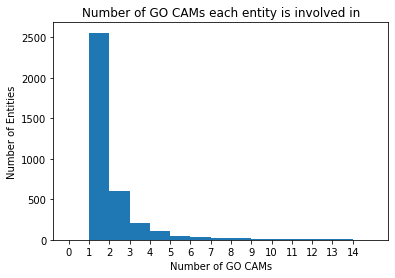

In [18]:
D = build_dict(data_cleaned)
x = []
for key in D:
    num_gocams = len(D.get(key))
    x.append(num_gocams)
plt.hist(x, bins=15, range=(0,15))
plt.xlabel("Number of GO CAMs")
plt.ylabel("Number of Entities")
plt.title("Number of GO CAMs each entity is involved in")
plt.xticks(np.arange(0,15))